# Etivity 3: Face Recognition

In this assignment, we will perform facial verification with the  [Labelled Faces in the wild (LFW)](http://vis-www.cs.umass.edu/lfw/) dataset. 

You will complete Section 3 of this Notebook which constructs the Siamese Neural Network for the LFW Face Matching Task.  4/5/6.

![](https://github.com/tonyscan6003/etivities/blob/main/face_det-Page-3.jpg?raw=true)

## Dataset:
In the lessons we have seen the Facial Identification and Verification tasks. There is a gallery of individuals that we train on, and during test we attempt to match probe images to the gallery. In the open set case the probe images will contain faces not included in the training set. The LFW dataset uses a slightly different train/test protocol to standard Facial Verification. LFW focuses on the problem of face matching. A system is trained to determine if a pair of faces match or not. This is similar to the Facial verification task (during test), however the LFW protocol requires that the training and test splits are entirely independent. Thus no identity in the LFW training set will appear in the LFW test set. (For further information see section III of the [LFW paper](http://vis-www.cs.umass.edu/lfw/lfw.pdf))   

In this notebook we use the Unrestricted training protocol for LFW. As detailed in section IV of the [LFW paper](http://vis-www.cs.umass.edu/lfw/lfw.pdf), the unrestricted protocol allows us to form as many matched pairs as required from the available set of images & image labels. This allows us to increase the amount of training pairs, which is useful for neural network training. (In the alternative restricted protocol the number of image pairs is limited see file [pairs.txt](http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt)). We also note that many large scale/high accuracy Facial recognition systems still use the LFW test set as a benchmark. These systems will have been trained using large amounts additional training data. It is important that none of the identities in the additional training set are also included in the LFW test set. ( [See paper on LFW reporting](https://vis-www.cs.umass.edu/lfw/lfw_update.pdf))   

## Network Architecture:
In this assignment we can use the principle of Deep Metric Learning to solve the LFW task. As we have seen in the paper by [Chopra](https://ieeexplore.ieee.org/document/1467314) (2005) a Siamese architecture can be constructed to construct a mapping for the facial image, such that the faces can be easily distinguished by their distance in the embedding space. The related paper by [Hadsell](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf) (2006) details the contrastive loss function (with margin) that is more suitable to implement than the energy based function detailed in the original paper. 

*  An example of a suitable siamese network architecture is seen in "[Small 
Sample Face Recognition Algorithm based on Novel Siamese Network](http://www.jips-k.org/q.jips?cp=pp&pn=621)" Note that this paper claims >90% accuracy on the LFW test set, however it appears that training and test data have been mixed invalidating this result!

* It is recommended for this etivity to use the Kearas [functional API](https://keras.io/guides/functional_api/). This allows models to be called like layers. It also allows the same instance of the base CNN of the siamese network to be called twice, thus effectively implementing weight sharing between the two CNNs.

* The Contrastive loss function can be implemented as a [custom loss](https://keras.io/api/losses/). Once the loss function has the form f(y_true,y_pred) it can be used in place of any standard loss function when compiling the keras model (before using .fit method). A place holder for the loss function is given below. (We note in the siamese case y_true will always be the training data label (0 or 1) and y_pred will be the distance between the outputs of the network).  






#House Keeping

In [ ]:
from __future__ import print_function

import glob
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, LocallyConnected2D, Dropout, MaxPool2D, multiply, Permute, Reshape
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D, MaxPooling2D, Input, Flatten, concatenate, Lambda, Concatenate, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

import numpy as np

To ensure this assignment runs as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU. 

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

#1. Load Dataset

As detailed above, we will be using the well know Labelled faces in the wild dataset for face verification. [LFW dataset](https://www.tensorflow.org/datasets/catalog/lfw). 


In [ ]:
!apt-get install wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [ ]:
# "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
!wget "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"

--2022-12-04 10:13:42--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz.3’

lfw-deepfunneled.tg 100%[===================>] 103.72M  12.0MB/s    in 10s     

2022-12-04 10:13:53 (10.2 MB/s) - ‘lfw-deepfunneled.tgz.3’ saved [108761145/108761145]



In [ ]:
!tar -xvf "lfw-deepfunneled.tgz"

Streaming output truncated to the last 5000 lines.
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0012.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0013.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0014.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0015.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0016.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0017.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0018.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0019.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0020.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0021.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg
lfw-deepfunne

In [ ]:
# Find list of people from file structure
id_list = os.listdir('lfw-deepfunneled')
# Create a dictionary between identity and images of person
id_img_dict = {}
for id in id_list:
   imgs = glob.glob('lfw-deepfunneled/'+id+'/*.jpg')
   id_img_dict[id] = imgs


In [ ]:
# Load .txt files of restricted set pairs and unrestricted set people
!wget "http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt"
!wget "http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt"
!wget "http://vis-www.cs.umass.edu/lfw/peopleDevTrain.txt"
!wget "http://vis-www.cs.umass.edu/lfw/peopleDevTest.txt"

--2022-12-04 10:13:57--  http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56579 (55K) [text/plain]
Saving to: ‘pairsDevTrain.txt.3’

pairsDevTrain.txt.3 100%[===================>]  55.25K   119KB/s    in 0.5s    

2022-12-04 10:13:58 (119 KB/s) - ‘pairsDevTrain.txt.3’ saved [56579/56579]

--2022-12-04 10:13:58--  http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26002 (25K) [text/plain]
Saving to: ‘pairsDevTest.txt.3’

pairsDevTest.txt.3  100%[===================>]  25.39K   107KB/s    in 0.2s    

2022-12-04 10:13:59 (107 KB/s) - ‘pairsDevTest.txt.3’ saved 

In [ ]:

#  import as numpy array and operate on lengths differently
pairsDevTrain_file = open('pairsDevTrain.txt')
# Skip first line
next(pairsDevTrain_file)
train_pairs = [np.array( line.split()) for line in pairsDevTrain_file]

#  import as numpy array and operate on lengths differently
pairsDevTest_file = open('pairsDevTest.txt')
# Skip first line
next(pairsDevTest_file)
test_pairs = [np.array( line.split()) for line in pairsDevTest_file]
val_pairs = random.sample(test_pairs,256)

#  import as numpy array and operate on lengths differently
peopleDevTrain_file = open('peopleDevTrain.txt')
# Skip first line
next(peopleDevTrain_file)
train_people = [np.array( line.split()) for line in peopleDevTrain_file]

#  import as numpy array and operate on lengths differently
peopleDevTest_file = open('peopleDevTest.txt')
# Skip first line
next(peopleDevTest_file)
test_people = [np.array( line.split()) for line in peopleDevTest_file]
val_people = random.sample(test_people,256)

# 2A. Prepare Data

As we will use the LFW Unrestricted Training protcol we need to form training pairs from the data contained in the [people file](http://vis-www.cs.umass.edu/lfw/peopleDevTrain.txt) that we have downloaded into the array `train_people`. 
The function `gen_unrestricted_pairs` in the code cell below iterates through the `train_people` array. For each ith individual with greater then 1 available image, it will create matching pairs using a maximum $n$ images. This will create $n_{pair} = \lfloor{(n^2-n)/2}\rfloor$. An equal number of unmatched pairs are then created using images from the ith idividual and a single image from $n_{pair}$ other indivduals. This results in a balanced dataset with the same number of matching and non-matching pairs. 

In [ ]:
p_max = 8 # Maximum number of images to used to form pairs for any given identity


# Function to create list of unrestricted pairs 
unrestricted_pairs = []
def gen_unrestricted_pairs(people_array):
   n_people = int(np.shape(people_array)[0])
   # Subfunction that creates all image pairs
   def image_pairs_ind(id,tot_img):
      '''
      input: tot_img   #Total number of images to be included
             id        # String for name of person   
      ouput: pairs_ind #Output format ID, ID, img1, img2 (where images start at 1) same form as pairsDevTrain files
      '''
      k=0
      if tot_img ==2:
         pairs_ind = [id,1,id,2,'0']
      else:
        for i in range(tot_img): 
          for j in np.arange(i+1,tot_img):
            if k==0:
              pairs_ind = [id,i+1,id,j+1,'0']
            else:  
              next_ind = np.array([id,i+1,id,j+1,'0'])
              pairs_ind = np.vstack((pairs_ind,next_ind))  
            k=+1 
      return pairs_ind                   
   
   # Sub function that creates and array of negative matching id's and index images
   # Can generate at least any equal no of negative pairs to positive
   # If no positive pairs exist then return one negative pair   
   def neg_pair_id_ind(id,id_no,n_max):
      '''
      input: 
             id        # String for name of person   
             id_no     # line number for id from person_array
             n_max     # needs to be same as number of generated pairs
      ouput: pairs_ind #Output format ID, ID, img1, img2 (where images start at 1)
      ''' 
      sel_lines = np.append(np.arange(0,id_no),np.arange(id_no+1,n_people)) #  Range of ids excluding current id
      neg_id_lines = np.random.choice(sel_lines, n_max, replace=True)      #  Choose img_tot ids from range of ids 
      # Iterate through id's select one image at random where multiple are available and append to array
      k=0
      for neg_id_line in neg_id_lines:
            neg_id=people_array[neg_id_line][0]                       # Identity
            neg_imgs = int(people_array[neg_id_line][1] )               # Number of Images
            sel_img =  np.random.choice(neg_imgs) if neg_imgs >1 else 1
            if k ==0:
              pairs_ind = [id,k+1,neg_id,neg_imgs,'1'] # use k for positive image index, will increment as go through negative ids  
            else:
              pairs_ind = np.vstack((pairs_ind,[id,k+1,neg_id,neg_imgs,'1']))
            k=+1  
      return pairs_ind 


   m =0
   for line in people_array[0:n_people-2]:       # Iterate each line
   #for line in people_array[0:10]:
      id=line[0]                                # Identity
      tot_img = int(line[1])                        # Number of Images
      n_max = min(p_max,tot_img)                # Limits number of pos/neg pairs for given identity (could be random)
      num_uniq_pair = int(np.floor((n_max**2-n_max)/2)) # Maximum number of unique pairs in an array
      
      if n_max>1:      # Working with images that can produce postive pair only
        next_pos_ind = image_pairs_ind(id,n_max)     # Sub function that returns possible positive permutations for identity
        next_neg_ind = neg_pair_id_ind(id,m,num_uniq_pair)  # Subfunction that returns other identities.
        if m ==0:
          unrestricted_pairs = next_pos_ind
          unrestricted_pairs=np.vstack((unrestricted_pairs,next_neg_ind))
        else:
          unrestricted_pairs=np.vstack((unrestricted_pairs,next_pos_ind))
          unrestricted_pairs=np.vstack((unrestricted_pairs,next_neg_ind))
        m=+1  
   return unrestricted_pairs

In [ ]:
# Convert Train, test and val data using this function.
ur_train_pairs = gen_unrestricted_pairs(train_people)
ur_val_pairs = gen_unrestricted_pairs(val_people)
ur_test_pairs = gen_unrestricted_pairs(test_people)
# Calculate number of available batches for trainguing
n_batch = np.floor(np.shape(ur_train_pairs)[0]/32)

seed = 2545
print(np.shape(ur_train_pairs))
rng = np.random.default_rng(seed) 
np.random.shuffle(ur_train_pairs)
np.random.shuffle(ur_val_pairs)
np.random.shuffle(ur_test_pairs)
print(ur_train_pairs[:,1:20])

(16338, 5)
[['1' 'Ricardo_Lagos' '5' '0']
 ['4' 'Mike_Krzyzewski' '6' '0']
 ['6' 'Javier_Solana' '7' '0']
 ...
 ['2' 'Pervez_Musharraf' '18' '1']
 ['1' 'Felicity_Huffman' '1' '1']
 ['2' 'Sergio_Vieira_De_Mello' '7' '0']]


# 2B. Setup Generator/Tensorflow Dataset
In the previous step we have created an array of matching and non-matching pairs (in alphabetical order). In this next step we construct a python generator (using `create_generator` function). This generator yields images paths and match/non-match labels. The generator must be a callable and have no arguments. As detailed [here](https://tensorexamples.com/2020/07/27/Using-the-tf.data.Dataset.html), the file is passed into the function name space by nesting the generator within a callable function.


*   See "[How to quickly build a Tensorflow Trainig Pipeline](https://www.hosstechnology.com/post/how-to-quickly-build-a-tensorflow-training-pipeline)" for further details.

Note that the input pairs_array is randomly permuted by the generator. Therefore on each Epoch the order of the face pairs will be different, this will help generalise training. 

In [ ]:
batch_size = 32 # Default Batch size (can be adjusted)
H_trg =120       # Image Height (fixed)
W_trg =120       # image Width (fixed)



In [ ]:
# Create a generator to yield training images/label for training pairs
# Setup to select at random (won't have epochs)


def create_generator(pairs_array):
  # Randomly permute array 
  #pairs_array= np.random.permutation(pairs_array)
  # Convert arrays to iterators to include in generator
  #array_iter= iter(pairs_array)

  def gen_rnd_pairs():
    no_lines = np.shape(pairs_array)[0]
    k=0
    while True: 
       # Select a pair of unique identities at random  
       #line_no = np.random.choice(no_lines)
       #line = pairs_array[line_no]
       # Select lines seqentially
       line = pairs_array[k]

       id1=line[0]
       id2=line[2]  
       img_no1 = line[1]
       img_no2 = line[3]
       img_path1=id_img_dict[id1][int(img_no1)-1] 
       img_path2=id_img_dict[id2][int(img_no2)-1]
       y_label = line[4]  
       
       # Allocate images to IDs 
       yield [img_path1,img_path2],y_label
       if k > batch_size*int(n_batch):
         k=0
         np.random.shuffle(pairs_array)
       else:  
         k+=1

  return gen_rnd_pairs


Given the generator function, we can turn this into a tensorflow dataset uisng the [tf.data.Dataset.from_generator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method. Within the function `gen_tr_datasets` that sets up the dataset, we also map the function `data_pipe` to the dataset. This sub-function reads images from the paths output by the generator.


In [ ]:
# Subfunction to read images from file path, resize, scale and offset.
def data_pipe(img_paths,label):
  img1_file = tf.io.read_file(img_paths[0])
  img2_file = tf.io.read_file(img_paths[1])
  img1 = tf.image.decode_image(img1_file)
  img2 = tf.image.decode_image(img2_file)
  img1 = tf.image.convert_image_dtype(img1, tf.float32) # Cast and normalize the image to [0,1]
  img2 = tf.image.convert_image_dtype(img2, tf.float32) # Cast and normalize the image to [0,1]
  img1 = tf.image.resize_with_pad(img1, H_trg,W_trg) # Resize all image
  img2 = tf.image.resize_with_pad(img2, H_trg,W_trg) # Resize all images
  # Scale image as required.
  img1 = img1-0.5
  img2 = img2-0.5
  return [img1,img2],label

# Convert generator into tensorflow dataset
def gen_tr_datasets(pairs_array):    
    # Define Datasets 
    gen_rnd_pairs = create_generator(pairs_array)
    tr_dataset = tf.data.Dataset.from_generator(gen_rnd_pairs, output_signature=(
         tf.TensorSpec(shape=(2,), dtype=tf.string),tf.TensorSpec(shape=(), dtype=tf.int8)))
    tr_dataset = tr_dataset.map(data_pipe)
    tr_dataset = tr_dataset.batch(batch_size) 
    return tr_dataset



Convert the python arrays into datasets.

In [ ]:

train_dataset = gen_tr_datasets(ur_train_pairs)
test_dataset = gen_tr_datasets(ur_test_pairs)
val_dataset = gen_tr_datasets(ur_val_pairs)


In [ ]:
print(train_dataset.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 2, 120, 120, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int8, name=None))>


Plot some examples of the training dataset.

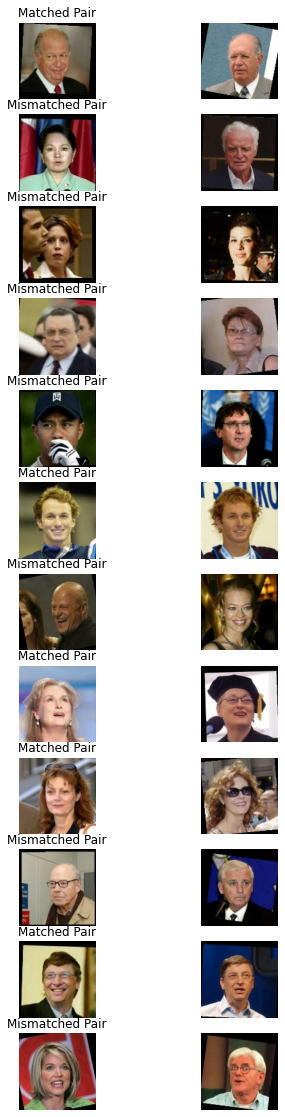

In [ ]:
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(n_plots,2,figsize=(6,20))
label_str = ('Matched Pair','Mismatched Pair')
for imgs,label in train_dataset.take(n_plots):  # Only take a single example
  img1=np.squeeze(imgs[:,0,:,:,:])
  img2=np.squeeze(imgs[:,1,:,:,:])
  axarr[i,0].imshow(img1[0,:,:,:]+0.5)
  axarr[i,0].axis('off')
  axarr[i,0].set_title(label_str[int(label[0])])
  axarr[i,1].imshow(img2[0,:,:,:]+0.5)
  axarr[i,1].axis('off')
  i = i+1
plt.show()






 


# 3A. Build CNN Forming Branches of Siamese network
In this section you will construct a convolution network `conv_network` that can be used as the branches of the siamese network. An example of a suitable siamese network architecture is seen in "Small Sample Face Recognition Algorithm based on Novel Siamese Network". The first archiecture in the paper "SiameseFace1", is similar to the VGG network used for image classification and is straightfoward to implement a similar network to this. You can however explore with your own architectures for this exercise.
* A repeating unit `repeat_unit` is given in the code cell below and containing many of the layers described below allows convolution type networks to be easilty constructed.


 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 
 * Locally connected convolution layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LocallyConnected2D) Local connnection is used in some early networks for facial recognition. It is possible to implement these in Tensorflow keras, however they are very memory intensive and slow to run.
 * Batch Normalization layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) 
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) 
 

In [ ]:
# Example of a Basic Repeating unit

def repeat_unit(inputs, num_channels=16, kernel_size=3,
                 strides=1, activation='relu', batch_normalization=False):
    """
    inputs: Input to repeat unit.
    num_channels: number of channels in convolution layer of repeat unit, nominally = 16
    kernel_size: number of kernels to use in convolution, nominally = 3
    strides: number of strides for kernel, nominally = 1
    activation: type of activation applied to output of convolution, nominally ReLU. 
    x = output of repeat_unit
    """
    conv = Conv2D(num_channels, kernel_size=kernel_size, strides=strides, padding='same')
    x = conv(inputs)
    
    if activation is not None:
        x = Activation(activation)(x)

    if batch_normalization:
        x = BatchNormalization()(x)

    return x


In [ ]:
def conv_network(input_shape=(120, 120, 3)):
    """
    Inputs:
       input Shape: (Define H,W, no. channels) of network input
                    used in Model Input definition below
    Output 
       model:       keras Model returned by this function.                          
    """

    # Define input of model
    inputs = Input(shape=input_shape)
    ### Your Network Here #####

    x = repeat_unit(inputs=inputs, num_channels=32,kernel_size=5,batch_normalization=True)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = repeat_unit(inputs=x, num_channels=128,kernel_size=3, batch_normalization=True)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.2)(x)

    x = repeat_unit(inputs=x, num_channels=256,kernel_size=3,batch_normalization=True)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = repeat_unit(inputs=x, num_channels=256,kernel_size=3,batch_normalization=True)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.2)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(200, activation='relu',kernel_regularizer=regularizers.L2(1e-2),
              bias_regularizer=regularizers.L2(1e-2),
              kernel_initializer='he_normal')(x)
    x = Dense(200, activation='relu')(x)

    # Model definition
    model = Model(inputs=inputs, outputs=x)
    return model
base_net_test = conv_network((120,120,3))
base_net_test.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 120, 120, 32)      2432      
                                                                 
 activation_12 (Activation)  (None, 120, 120, 32)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 120, 120, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 128)       3699

## 3B: Siamese Top Level

In the code cell below you can complete the top level of the Siamese Network. The top level will need to contain 2 instances of the CNN model. The Kearas [functional API](https://keras.io/guides/functional_api/) usefully allows models to be called like layers and therefore allows the same instance of the base CNN of the siamese network to be called twice. Both instances will share the same weights.

It is also recommended to implement the distance function $D_w(\overrightarrow{X_1},\overrightarrow{X_2})$ detailed in the [Hadsell](https://ieeexplore.ieee.org/document/1640964) paper as separate model within the Siamese network. The distance calculated can then be passed to the custom loss function as descibed in the next step. The functional API allow the distance network to have two inputs one from each of the CNN branches.

* Models with multiple Inputs and Outputs is discussed [here](https://keras.io/guides/functional_api/) (see 1/2 way down page)

In [ ]:
from joblib.externals.cloudpickle.cloudpickle import instance
def distance_network(input_1, input_2):

  distance_model =tf.math.sqrt(tf.math.maximum(tf.math.reduce_sum(tf.math.square(input_1 - input_2), axis=1, keepdims=True), 
                                                                tf.keras.backend.epsilon()))
  return distance_model
 
# Top level, ensure weight sharing by processing two inputs in parallel with same network. 
def siamese_network(input_shape=(2,120, 120,3),conv_net=conv_network()):
    """
    Inputs:
       input Shape: (Define H,W, no. channels) of network input
                    used in Siamese Model Input definition below
      conv_net: This defines the conv_network to use.
    Output 
       model:       keras Model returned by this function.                          
    """
    inputs = Input(shape=input_shape)

    branch_network = conv_net
    input_x1 = inputs[:,0]
    input_x2 = inputs[:,1]

    gw1_output = branch_network(input_x1)
    gw2_output = branch_network(input_x2)
    dist = distance_network(gw1_output, gw2_output)
    siamese_model = Model(inputs=inputs, outputs=dist)

    return siamese_model


## 3C: Loss Function
We can use the "contrastive loss" shown in paper by [Hadsell 2006](https://ieeexplore.ieee.org/document/1640964). The loss function can be implemented in the custom loss function `contrastive_loss`. As this function has the form $f(y_{true},y_{pred})$ it can be complied and used in the Keras .fit training method. 

In [ ]:
def contrastive_loss(y_true, y_pred):
    '''
    Inputs: 
      # y_true is binary prediction (0 similar 1 disimlar)
      # y_pred is distance between siamese networks
    Outputs:
      # loss  calculated loss
    '''
    m = 1
    y = tf.cast(y_true, tf.float32)
    dw = tf.cast(y_pred, tf.float32)
    
    loss = (((1 - y)*0.5*(dw**2))+(y*0.5*((tf.math.maximum(m-dw,0))**2)))

    return loss

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 4. Compile the Model
Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. We can include our custom contrastive loss function, and choose Adam as the optimiser. 




Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 2, 120, 120  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 120, 120, 3)  0          ['input_8[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_5 (Sl  (None, 120, 120, 3)  0          ['input_8[0][0]']                
 icingOpLambda)                                                                             

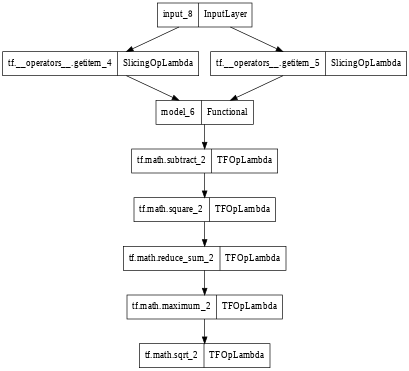

In [ ]:
model = siamese_network()
model.compile(loss=contrastive_loss, optimizer=Adam(),metrics=["accuracy"])
model.summary()

# Uncomment the following line to plot the model visually - warning, even for this simplified ResNet, it is quite large!
keras.utils.plot_model(model, dpi=48)


!!!Check model consumes data

In [ ]:
for imgs,label in train_dataset.take(1):  # Only take a single example
  y=model(imgs,training=False)
  print(np.shape(imgs))
  print(np.shape(y))
  print(y)

(32, 2, 120, 120, 3)
(32, 1)
tf.Tensor(
[[0.15716912]
 [0.16550586]
 [0.11924373]
 [0.13268116]
 [0.22879337]
 [0.14702758]
 [0.09933284]
 [0.15470871]
 [0.13418466]
 [0.12191942]
 [0.1852966 ]
 [0.14550361]
 [0.08502364]
 [0.19528069]
 [0.11852097]
 [0.17195037]
 [0.17132908]
 [0.14467709]
 [0.14758247]
 [0.14594057]
 [0.12806149]
 [0.23209295]
 [0.13838406]
 [0.13353314]
 [0.13085645]
 [0.20097776]
 [0.09963793]
 [0.14271909]
 [0.12585343]
 [0.13445318]
 [0.14322165]
 [0.14470807]], shape=(32, 1), dtype=float32)


# 5. Model Training

We will now train the complied model on the LFW dataset using the tensorflow keras `model.fit` method. 



In [ ]:
epochs = 5
history = model.fit(train_dataset,epochs=epochs,steps_per_epoch=int(n_batch),validation_data=val_dataset,validation_steps=2)
#history = model.fit(train_dataset,epochs=epochs,steps_per_epoch=32,validation_data=val_dataset,validation_steps=2)

Epoch 1/5
510/510 [==============================] - 44s 84ms/step - loss: 2.3446 - accuracy: 0.5550 - val_loss: 0.9767 - val_accuracy: 0.6094
Epoch 2/5
510/510 [==============================] - 40s 78ms/step - loss: 0.5704 - accuracy: 0.6743 - val_loss: 0.3229 - val_accuracy: 0.7188
Epoch 3/5
510/510 [==============================] - 40s 79ms/step - loss: 0.2348 - accuracy: 0.7279 - val_loss: 0.1625 - val_accuracy: 0.7031
Epoch 4/5
510/510 [==============================] - 40s 79ms/step - loss: 0.1337 - accuracy: 0.7568 - val_loss: 0.1270 - val_accuracy: 0.7188
Epoch 5/5
510/510 [==============================] - 41s 81ms/step - loss: 0.0962 - accuracy: 0.7858 - val_loss: 0.1263 - val_accuracy: 0.6406


We will plot the loss and accuracy for the training and validation data sets.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


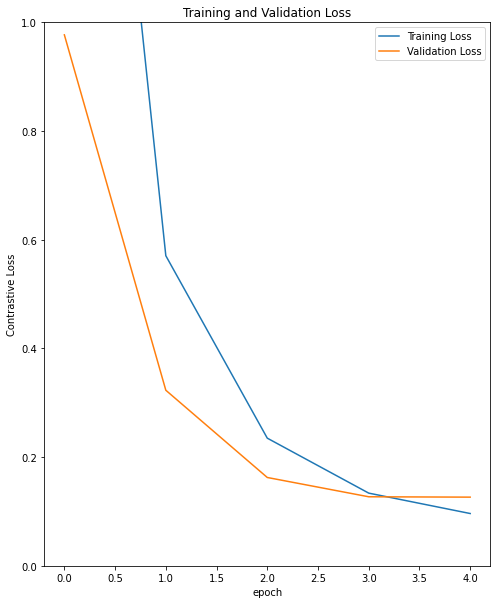

In [ ]:
def plot_loss(history):
  print(history.history.keys())


  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 10))
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Contrastive Loss')
  plt.ylim([0,1])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()
plot_loss(history)

# 6. Model Testing
The model will output a distance, we must set a threshold value that determines if the predicted label should be 0 for a match or 1 for non-match. You can inspect the output of your model to determine the optimal threshold. In the code cells we create a classification report, a confusion matrix and also plot a few examples from the test set.

Iterate through n_test batches and store the predicted and ground truth labels in numpy arrays.

In [ ]:
def predictions(model,threshold=.5):
  n_test = 32 # number of batches to use
  store_predictions = []
  store_labels = []
  for image_batch,label_batch in test_dataset.take(n_test):
      distance = model(image_batch,training=False)
      # Threshold distance and convert to prediction
      predictions = distance>threshold
      store_predictions.append(predictions)
      store_labels.append(label_batch)
  y_pred = 1.0*(np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size))))
  y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))
  return y_true, y_pred
y_true, y_pred = predictions(model,threshold=.52)

Create and plot a confusion matrix.

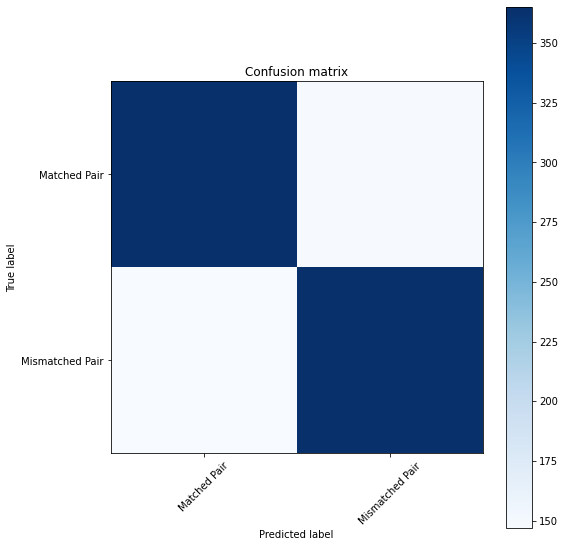

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
label_str = ('Matched Pair', 'Mismatched Pair')
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm)

Generate & print the classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

                 precision    recall  f1-score   support

   Matched Pair       0.71      0.71      0.71       512
Mismatched Pair       0.71      0.71      0.71       512

       accuracy                           0.71      1024
      macro avg       0.71      0.71      0.71      1024
   weighted avg       0.71      0.71      0.71      1024



Plot some test images and predicted labels.

tf.Tensor(
[[0.55813074]
 [0.4596606 ]
 [0.59832156]
 [0.58841676]
 [0.45555532]
 [0.3179709 ]
 [0.81187314]
 [0.31822774]
 [0.113066  ]
 [0.13911055]
 [1.4131608 ]
 [0.47858465]
 [0.8153608 ]
 [0.23951298]
 [0.11721732]
 [0.41487038]
 [0.46780926]
 [0.69761753]
 [0.7589552 ]
 [0.28132188]
 [0.1334885 ]
 [0.49324563]
 [0.4790911 ]
 [0.3826916 ]
 [0.15496539]
 [0.25966308]
 [0.39188844]
 [0.38721147]
 [0.3323132 ]
 [0.5662251 ]
 [0.10359485]
 [0.38227662]], shape=(32, 1), dtype=float32)
Predictions:
 [1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0.]


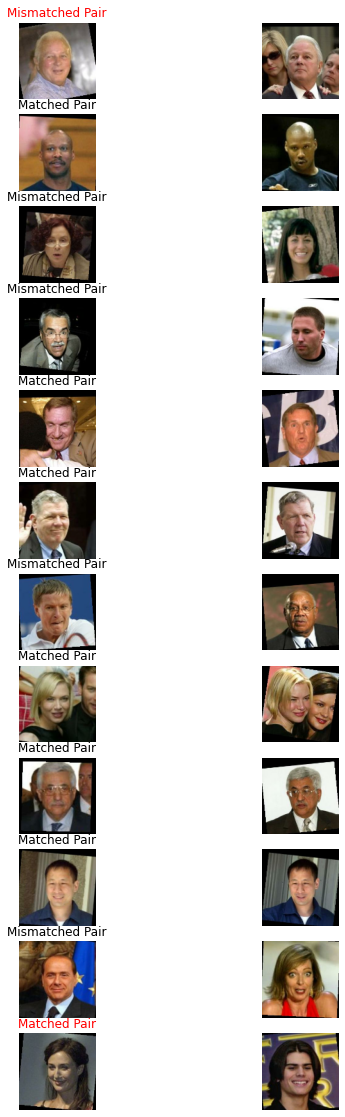

In [ ]:
def show_sample(model,threshold=.5):
  #Retrieve a batch of images from the test set
  image_batch, label_batch = test_dataset.as_numpy_iterator().next()
  #distances = model.predict_on_batch(image_batch)
  distance=model(image_batch,training=False)
  print(distance)

  # Apply a threshold as model returns distances
  predictions = 1.0*np.squeeze(distance>threshold)
  print('Predictions:\n', predictions)


  i=0
  n_plots = 12 # number of plots

  f, axarr = plt.subplots(n_plots,2,figsize=(8,20))

  for image_pair in image_batch[0:n_plots,:,:,:,:]:  
    img1=np.squeeze(image_pair[0,:,:,:])
    img2=np.squeeze(image_pair[1,:,:,:])
    axarr[i,0].imshow(img1[:,:,:]+0.5)
    axarr[i,0].axis('off')
    axarr[i,1].imshow(img2[:,:,:]+0.5)
    axarr[i,1].axis('off')

    color = ('black' if predictions[i] == int(label_batch[i]) else 'red') 
    axarr[i,0].set_title(label_str[int(predictions[i])],color=color)
    i = i+1
  plt.show()  
show_sample(model,threshold=.5)

# Siamese Model 2

**Siamese Model 2**
This model takes the concept outlined in SiameseFace2
[(Siamese paper)](file:///C:/Users/eocoeog/Downloads/journal_jips_JIPS-2018-14-6-1464%20(7).pdf)
There are 3 defined blocks, these are flattened and then concatenated together.
followed by a final dense layer.

In [ ]:
def conv_network_siamese_2(input_shape=(120, 120, 3)):
    """
    Inputs:
       input Shape: (Define H,W, no. channels) of network input
                    used in Model Input definition below
    Output 
       model:       keras Model returned by this function.                          
    """

    # Define input of model
    inputs = Input(shape=input_shape)
    ### Your Network Here #####
    x = repeat_unit(inputs=inputs, num_channels=32,kernel_size=5,batch_normalization=True)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = repeat_unit(inputs=x, num_channels=64,kernel_size=3, batch_normalization=True)
    b1 = MaxPooling2D(pool_size=(2, 2))(x)

    x = SpatialDropout2D(0.2)(b1)
    x = repeat_unit(inputs=x, num_channels=128,kernel_size=3,batch_normalization=True)
    b2 = MaxPooling2D(pool_size=(2, 2))(x)

    x = SpatialDropout2D(0.2)(b2)
    x = repeat_unit(inputs=x, num_channels=128,kernel_size=3,batch_normalization=True)
    b3 = MaxPooling2D(pool_size=(2, 2))(x)


    b1f = Flatten()(b1)
    b2f = Flatten()(b2)
    b3f = Flatten()(b3)
    
    x = concatenate([b1f,b2f,b3f])
    x = Dense(512, activation='relu',kernel_regularizer=regularizers.L2(1e-2),
              bias_regularizer=regularizers.L2(1e-2),
              kernel_initializer='he_normal')(x)
    # x = Dense(400, activation='relu',kernel_regularizer=regularizers.L2(1e-2),
    #           bias_regularizer=regularizers.L2(1e-2),
    #           kernel_initializer='he_normal')(x)

    # Model definition
    model = Model(inputs=inputs, outputs=x)
    return model

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 2, 120, 120  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.__operators__.getitem_24 (S  (None, 120, 120, 3)  0          ['input_28[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_25 (S  (None, 120, 120, 3)  0          ['input_28[0][0]']               
 licingOpLambda)                                                                           

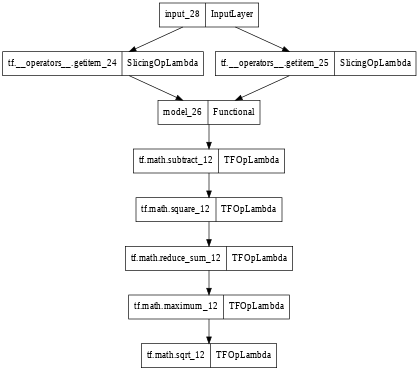

In [ ]:
model_2 = siamese_network(conv_net= conv_network_siamese_2())
model_2.compile(loss=contrastive_loss, optimizer=Adam(),metrics=["accuracy"])
model_2.summary()

# Uncomment the following line to plot the model visually - warning, even for this simplified ResNet, it is quite large!
keras.utils.plot_model(model_2, dpi=48)

In [ ]:
for imgs,label in train_dataset.take(1):  # Only take a single example
  y2=model_2(imgs,training=False)
  print(np.shape(imgs))
  print(np.shape(y2))
  print(y2)

(32, 2, 120, 120, 3)
(32, 1)
tf.Tensor(
[[0.6266205 ]
 [0.6681887 ]
 [0.6436382 ]
 [0.82432556]
 [1.0324239 ]
 [0.68607247]
 [0.85185325]
 [0.76929003]
 [0.8852423 ]
 [0.78505486]
 [0.90701294]
 [0.72866017]
 [0.884072  ]
 [0.803509  ]
 [0.5150754 ]
 [0.8258468 ]
 [0.76855236]
 [0.8785699 ]
 [1.1566807 ]
 [0.737633  ]
 [0.9120477 ]
 [0.48130396]
 [1.0016683 ]
 [0.80306053]
 [0.6961172 ]
 [0.9415218 ]
 [0.68189037]
 [0.8171199 ]
 [0.75851035]
 [0.8060836 ]
 [0.61485434]
 [0.92144245]], shape=(32, 1), dtype=float32)


In [ ]:
epochs = 5
history_2 = model_2.fit(train_dataset,epochs=epochs,steps_per_epoch=int(n_batch),validation_data=val_dataset,validation_steps=2)
#history = model.fit(train_dataset,epochs=epochs,steps_per_epoch=32,validation_data=val_dataset,validation_steps=2)

Epoch 1/5
510/510 [==============================] - 43s 82ms/step - loss: 15.6055 - accuracy: 0.5022 - val_loss: 6.7400 - val_accuracy: 0.4844
Epoch 2/5
510/510 [==============================] - 40s 78ms/step - loss: 5.0789 - accuracy: 0.5000 - val_loss: 35.7981 - val_accuracy: 0.4688
Epoch 3/5
510/510 [==============================] - 41s 79ms/step - loss: 33.0578 - accuracy: 0.5037 - val_loss: 23.2871 - val_accuracy: 0.5156
Epoch 4/5
510/510 [==============================] - 39s 77ms/step - loss: 21.7338 - accuracy: 0.4998 - val_loss: 16.3952 - val_accuracy: 0.4844
Epoch 5/5
510/510 [==============================] - 40s 78ms/step - loss: 18.5176 - accuracy: 0.5007 - val_loss: 15.4081 - val_accuracy: 0.4844


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


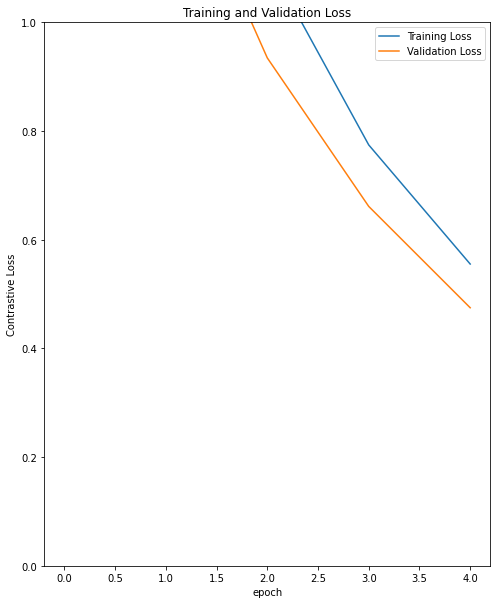

In [ ]:
plot_loss(history_2)

In [ ]:
y_true2, y_pred2 = predictions(model_2,threshold=.5)

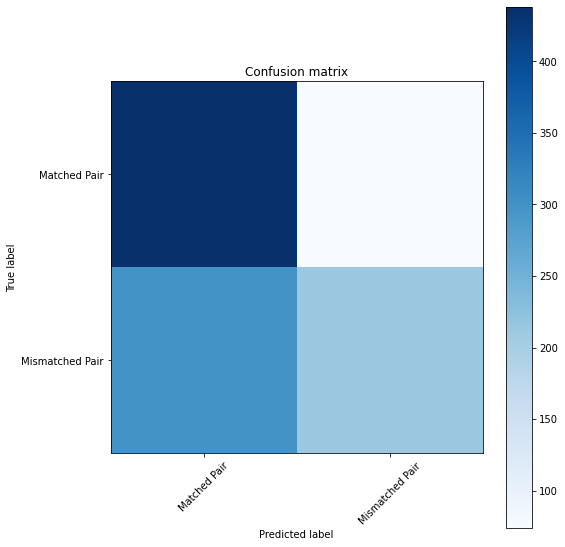

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true2, y_pred2)
label_str = ('Matched Pair', 'Mismatched Pair')
plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true2, y_pred2, target_names=label_str))

                 precision    recall  f1-score   support

   Matched Pair       0.59      0.86      0.70       512
Mismatched Pair       0.74      0.42      0.53       512

       accuracy                           0.64      1024
      macro avg       0.67      0.64      0.62      1024
   weighted avg       0.67      0.64      0.62      1024



tf.Tensor(
[[0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]
 [0.00031623]], shape=(32, 1), dtype=float32)
Predictions:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


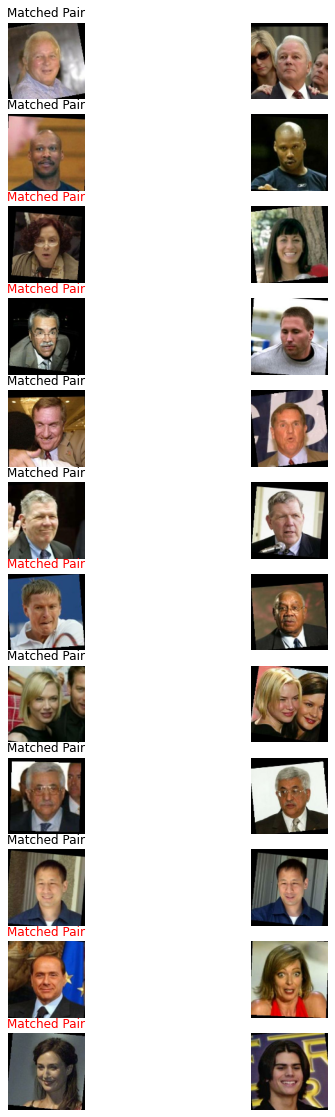

In [ ]:
show_sample(model_2,threshold=.5)  

# Please Leave a note here explaining your approach/results for the e-moderator.



**Siamese 1** <br>
The siamese model was difficult to construct due to dimensions, input shapes etc... Initially a very small model was constructed with only 185k params but this performed badly due to lack of weights. This was replaced by a very large model which overfitted the training data. Eventually models between 5million-20million provided an ideal accuracy on test set (approx. 70%)

To cut down on training time Batch normalization were avoided as the increased training to 5 mins. They also returned poor results. When set to false, the output of the model is given between 0 - 1 which made finding an optimal threshold easier. Approx. .5 provides the best results for testset.

A squeeze excite block was introduced, but a poor performance was returned, the accuracy decreased down to 50% accuracy.

**Siamese 2** <br>

The second siamese model introduces a ResNet architecture. Here a similar model is created but where 3 layers are flatten and concatenated together before the final dense layer. This creates a very large flatten layer. The hope is improve the accuracy of the model, as by doing this the params are increased. In this case the params are increased from 13.7million to 47.6million, thus increasing training time and size of the model.


**Summary** <br>
 The findings of Siamese 2 didn't show any significant improvement in the model performance except overfitting. By looking at the loss graph and the accuracy values of the epochs the concatenation of the 3 layers reduces the overfitting of the model. But for accuracy comparison to training time model 1 is a better solution in this case.
Overall the long term model 2 is ther better model as it negates overfitting better than model one thus making it more reliable.

